In [2]:

import argparse
import ast
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PaperCrawlerUtil.common_util import *
from PaperCrawlerUtil.constant import *
from PaperCrawlerUtil.crawler_util import *
from dgl.nn import GATConv
from dtaidistance import dtw
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter
from model import *
from funcs import *
from params_ipynb import *
from utils import *
from PaperCrawlerUtil.research_util import *

basic_config(logs_style=LOG_STYLE_ALL)
p_bar = process_bar(final_prompt="初始化准备完成", unit="part")
long_term_save = {}
args = params()
long_term_save["args"] = args.__str__()
if args.c != "default":
    c = ast.literal_eval(args.c)
    record = ResearchRecord(**c)
    record_id = record.insert(__file__, get_timestamp(), args.__str__())
p_bar.process(0, 1, 5)
source_emb_label2, source_t_adj, source_edge_labels2, lag, source_poi, source_data2, \
source_train_y, source_test_x, source_val_x, source_poi_adj, source_poi_adj2, dataname, target_train_x, \
th_mask_source2, th_mask_source, target_test_loader, target_poi, target_od_adj, \
source_dataset, mask_source, target_graphs, target_val_dataset, max_val, scity2, smin2, \
target_emb_label, tcity, source_road_adj2, gpu_available, source_edges2, \
mask_source2, source_poi_cos, source_data, source_graphs, lng_source, source_road_adj, target_d_adj, \
target_val_x, source_poi2, scity, target_t_adj, lat_source, lat_target, target_test_x, \
source_x, target_val_y, lng_source2, num_tuine_epochs, source_d_adj, source_edge_labels, source_prox_adj, \
source_loader, source_graphs2, transform, source_t_adj2, smax2, target_train_loader, \
source_test_dataset2, source_poi_cos2, source_od_adj2, target_s_adj, target_test_dataset, \
source_test_y2, source_y, source_dataset2, target_road_adj, source_test_loader, target_poi_adj, \
smax, start_time, target_test_y, lng_target, source_test_loader2, \
source_prox_adj2, target_data, source_x2, target_train_dataset, source_test_dataset, source_test_x2, source_od_adj, target_val_loader, smin, target_poi_cos, target_edge_labels, \
source_edges, source_train_x2, source_s_adj, source_y2, source_val_x2, source_emb_label, \
target_norm_poi, source_norm_poi, source_train_x, datatype, source_val_y, mask_target, \
source_train_y2, source_norm_poi2, source_s_adj2, num_epochs, lat_source2, min_val, target_edges, \
source_val_y2, target_prox_adj, source_loader2, source_test_y, source_d_adj, \
target_train_y, th_mask_target, device, p_bar = load_process_data(args, p_bar)

if args.need_third == 1:
    scity3 = args.scity3
    source_data3 = np.load("../data/%s/%s%s_%s.npy" % (scity3, dataname, scity3, datatype))
    lng_source3, lat_source3 = source_data3.shape[1], source_data3.shape[2]
    mask_source3 = source_data3.sum(0) > 0
    th_mask_source3 = torch.Tensor(mask_source3.reshape(1, lng_source3, lat_source3)).to(device)


    source_emb_label3 = masked_percentile_label(source_data3.sum(0).reshape(-1), mask_source3.reshape(-1))
    lag = [-6, -5, -4, -3, -2, -1]
    source_data3, smax3, smin3 = min_max_normalize(source_data3)
    source_train_x3, source_train_y3, source_val_x3, source_val_y3, source_test_x3, source_test_y3 = split_x_y(
        source_data3,
        lag)

    source_x3 = np.concatenate([source_train_x3, source_val_x3, source_test_x3], axis=0)
    source_y3 = np.concatenate([source_train_y3, source_val_y3, source_test_y3], axis=0)
    source_test_dataset3 = TensorDataset(torch.Tensor(source_test_x3), torch.Tensor(source_test_y3))
    source_test_loader3 = DataLoader(source_test_dataset3, batch_size=args.batch_size)
    source_dataset3 = TensorDataset(torch.Tensor(source_x3), torch.Tensor(source_y3))
    source_loader3 = DataLoader(source_dataset3, batch_size=args.batch_size, shuffle=True)
    source_poi3 = np.load("../data/%s/%s_poi.npy" % (scity3, scity3))
    source_poi3 = source_poi3.reshape(lng_source3 * lat_source3, -1)
    transform3 = TfidfTransformer()
    source_norm_poi3 = np.array(transform3.fit_transform(source_poi3).todense())
    source_prox_adj3 = add_self_loop(build_prox_graph(lng_source3, lat_source3))
    source_road_adj3 = add_self_loop(build_road_graph(scity3, lng_source3, lat_source3))
    source_poi_adj3, source_poi_cos3 = build_poi_graph(source_norm_poi3, args.topk)
    source_poi_adj3 = add_self_loop(source_poi_adj3)
    source_s_adj3, source_d_adj3, source_od_adj3 = build_source_dest_graph(scity3, dataname, lng_source3, lat_source3,
                                                                           args.topk)
    source_s_adj3 = add_self_loop(source_s_adj3)
    source_t_adj3 = add_self_loop(source_d_adj3)
    source_od_adj3 = add_self_loop(source_od_adj3)







    source_graphs3 = adjs_to_graphs([source_prox_adj3, source_road_adj3, source_poi_adj3, source_s_adj3, source_d_adj3])
    for i in range(len(source_graphs3)):
        source_graphs3[i] = source_graphs3[i].to(device)
    source_edges3, source_edge_labels3 = graphs_to_edge_labels(source_graphs3)

if args.need_geo_weight == 1:
    path2 = "./geo_weight/geo_weight{}_{}_{}_{}_{}.npy"
    geo_weight1 = np.load(path2.format(scity, tcity, datatype, dataname, args.data_amount))
    geo_weight2 = np.load(path2.format(scity2, tcity, datatype, dataname, args.data_amount))
    if args.need_third == 1:
        geo_weight3 = np.load(path2.format(scity3, tcity, datatype, dataname, args.data_amount))
virtual_city = None
virtual_poi = None
virtual_road = None
virtual_od = None
virtual_source_coord = None
if args.use_linked_region == 0:

    path = "./time_weight/time_weight{}_{}_{}_{}_{}.npy"
    s1_time_weight = np.load(path.format(scity, tcity, datatype, dataname, args.data_amount)).sum(2)
    s1_time_weight, _, _ = min_max_normalize(s1_time_weight)
    s1_time_weight = s1_time_weight.reshape(-1)

    s2_time_weight = np.load(path.format(scity2, tcity, datatype, dataname, args.data_amount)).sum(2)
    s2_time_weight, _, _ = min_max_normalize(s2_time_weight)
    s2_time_weight = s2_time_weight.reshape(-1)

    s1_regions = []
    s2_regions = []
    s3_regions = []

    if args.need_third == 1:
        s3_time_weight = np.load(path.format(scity3, tcity, datatype, dataname, args.data_amount)).sum(2)
        s3_time_weight, _, _ = min_max_normalize(s3_time_weight)
        s3_time_weight = s3_time_weight.reshape(-1)

    if args.need_geo_weight == 1:
        s1_time_weight = args.time_rate * s1_time_weight + args.geo_rate * geo_weight1
        s2_time_weight = args.time_rate * s2_time_weight + args.geo_rate * geo_weight2
        if args.need_third == 1:
            s3_time_weight = args.time_rate * s3_time_weight + args.geo_rate * geo_weight3
    threshold = args.threshold
    s1_amont = args.s1_amont
    s2_amont = args.s2_amont
    s3_amont = args.s3_amont
    time_threshold = args.cut_data

    s1_regions.extend([idx_1d22d(s1_time_weight.argsort()[-i], (source_data.shape[1], source_data.shape[2])) for i in
                       range(s1_amont)])
    s2_regions.extend([idx_1d22d(s2_time_weight.argsort()[-i], (source_data2.shape[1], source_data2.shape[2])) for i in
                       range(s2_amont)])
    if args.need_third == 1:
        s3_regions.extend(
            [idx_1d22d(s3_time_weight.argsort()[-i], (source_data3.shape[1], source_data3.shape[2])) for i in
             range(s3_amont)])



    s1_regions_, s2_regions_, s3_regions_ = [], [], []
    np_3_3 = []
    np_3_3_poi = []
    np_3_3_coord = []
    for i in s1_regions:
        if i in s1_regions_:
            continue
        b = list(yield_8_near((i[0], i[1]), (source_data.shape[1], source_data.shape[2])))
        for m in b:
            if m not in s1_regions_ and m in s1_regions:
                s1_regions_.append(m)
        count = 0
        temp1 = np.zeros((time_threshold, 3, 3))
        temp2 = np.zeros((3, 3, 14))
        temp3 = np.zeros((3, 3, 3))
        for p in range(3):
            for q in range(3):
                temp1[:, p, q] = source_data[0:time_threshold, b[count][0], b[count][1]]
                temp2[p, q, :] = source_poi[
                                 idx_2d_2_1d((b[count][0], b[count][1]), (source_data.shape[1], source_data.shape[2])),
                                 :]
                temp3[p, q, :] = np.array([b[count][0], b[count][1], 1])
                count = count + 1
        np_3_3.append(temp1)
        np_3_3_poi.append(temp2)
        np_3_3_coord.append(temp3)
        if len(s1_regions_) == len(s1_regions):
            break

    for i in s2_regions:
        if i in s2_regions_:
            continue
        b = list(yield_8_near((i[0], i[1]), (source_data2.shape[1], source_data2.shape[2])))
        for m in b:
            if m not in s2_regions_ and m in s2_regions:
                s2_regions_.append(m)
        count = 0
        temp1 = np.zeros((time_threshold, 3, 3))
        temp2 = np.zeros((3, 3, 14))
        temp3 = np.zeros((3, 3, 3))
        for p in range(3):
            for q in range(3):
                temp1[:, p, q] = source_data2[0:time_threshold, b[count][0], b[count][1]]
                temp2[p, q, :] = source_poi2[idx_2d_2_1d((b[count][0], b[count][1]),
                                                         (source_data2.shape[1], source_data2.shape[2])), :]
                temp3[p, q, :] = np.array([b[count][0], b[count][1], 2])
                count = count + 1
        np_3_3.append(temp1)
        np_3_3_poi.append(temp2)
        np_3_3_coord.append(temp3)
        if len(s2_regions_) == len(s2_regions):
            break

    for i in s3_regions:
        if i in s3_regions_:
            continue
        b = list(yield_8_near((i[0], i[1]), (source_data3.shape[1], source_data3.shape[2])))
        for m in b:
            if m not in s3_regions_ and m in s3_regions:
                s3_regions_.append(m)
        count = 0
        temp1 = np.zeros((time_threshold, 3, 3))
        temp2 = np.zeros((3, 3, 14))
        temp3 = np.zeros((3, 3, 3))
        for p in range(3):
            for q in range(3):
                temp1[:, p, q] = source_data3[0:time_threshold, b[count][0], b[count][1]]
                temp2[p, q, :] = source_poi3[idx_2d_2_1d((b[count][0], b[count][1]),
                                                         (source_data3.shape[1], source_data3.shape[2])), :]
                temp3[p, q, :] = np.array([b[count][0], b[count][1], 3])
                count = count + 1
        np_3_3.append(temp1)
        np_3_3_poi.append(temp2)
        np_3_3_coord.append(temp3)
        if len(s3_regions_) == len(s3_regions):
            break
    def is_integer(number):
        if int(number) == number:
            return True
        else:
            return False
    def is_3_product(number):
        if int(number) % 3 == 0:
            return True
        else:
            return False
    def crack(integer):
        start = int(np.sqrt(integer))
        factor = integer / start
        while not (is_integer(start) and is_integer(factor) and is_3_product(factor) and is_3_product(start)):
            start += 1
            factor = integer / start
        return int(factor), start
    shape = crack(len(np_3_3) * 9)

    virtual_city = np.zeros((time_threshold, shape[0], shape[1]))
    virtual_poi = np.zeros((shape[0], shape[1], 14))
    virtual_source_coord = np.zeros((shape[0], shape[1], 3))

    virtual_road = np.zeros((shape[0] * shape[1], shape[0] * shape[1]))
    virtual_od = np.zeros((shape[0] * shape[1], shape[0] * shape[1]))
    count = 0
    for i in range(0, shape[0], 3):
        for j in range(0, shape[1], 3):
            virtual_city[:, i: i + 3, j: j + 3] = np_3_3[count]
            virtual_poi[i: i + 3, j: j + 3, :] = np_3_3_poi[count]
            virtual_source_coord[i: i + 3, j: j + 3, :] = np_3_3_coord[count]
            count = count + 1
    for i in range(virtual_source_coord.shape[0] * virtual_source_coord.shape[1]):
        for j in range(virtual_source_coord.shape[0] * virtual_source_coord.shape[1]):
            m, n = idx_1d22d(i, (virtual_source_coord.shape[0], virtual_source_coord.shape[1]))
            p, q = idx_1d22d(j, (virtual_source_coord.shape[0], virtual_source_coord.shape[1]))
            if virtual_source_coord[m][n][2] == virtual_source_coord[p][q][2]:
                od = None
                road = None
                shape = None
                if virtual_source_coord[m][n][2] == 1:
                    od = source_od_adj
                    road = source_road_adj
                    shape = (source_data.shape[1], source_data.shape[2])
                elif virtual_source_coord[m][n][2] == 2:
                    od = source_od_adj2
                    road = source_road_adj2
                    shape = (source_data2.shape[1], source_data2.shape[2])
                elif virtual_source_coord[m][n][2] == 3:
                    od = source_od_adj3
                    road = source_road_adj3
                    shape = (source_data3.shape[1], source_data3.shape[2])
                c = idx_2d_2_1d(
                    (virtual_source_coord[m][n][0], virtual_source_coord[m][n][1]
                     ), shape)
                d = idx_2d_2_1d(
                    (virtual_source_coord[p][q][0], virtual_source_coord[p][q][1]
                     ), shape)
                c = int(c)
                d = int(d)
                virtual_od[i][j] = od[c][d]
                virtual_road[i][j] = road[c][d]
    for i in range(virtual_road.shape[0]):
        virtual_road[i][i] = 1
elif args.use_linked_region == 1:
    path = "./time_weight/time_weight{}_{}_{}_{}_{}.npy"
    s1_time_weight = np.load(path.format(scity, tcity, datatype, dataname, args.data_amount)).sum(2)
    s1_time_weight, _, _ = min_max_normalize(s1_time_weight)

    s2_time_weight = np.load(path.format(scity2, tcity, datatype, dataname, args.data_amount)).sum(2)
    s2_time_weight, _, _ = min_max_normalize(s2_time_weight)

    s1_regions = []
    s2_regions = []
    s3_regions = []

    if args.need_third == 1:
        s3_time_weight = np.load(path.format(scity3, tcity, datatype, dataname, args.data_amount)).sum(2)
        s3_time_weight, _, _ = min_max_normalize(s3_time_weight)

    if args.need_geo_weight == 1:
        s1_time_weight = args.time_rate * s1_time_weight + args.geo_rate * geo_weight1
        s2_time_weight = args.time_rate * s2_time_weight + args.geo_rate * geo_weight2
        if args.need_third == 1:
            s3_time_weight = args.time_rate * s3_time_weight + args.geo_rate * geo_weight3
    threshold = args.threshold
    s1_amont = args.s1_amont
    s2_amont = args.s2_amont
    s3_amont = args.s3_amont
    time_threshold = args.cut_data
    def dfs(maps, i, j):
        if i < 0 or i >= maps.shape[0] or j < 0 or j >= maps.shape[1] or maps[i][j] == False:
            return []
        maps[i][j] = False
        coord_list = []
        coord_list.append((i, j))
        for p in [-1, 0, 1]:
            for q in [-1, 0, 1]:
                if p == q and p == 0:
                    continue
                coord_list.extend(dfs(maps, i + p, j + q))
        return coord_list
    def calculate_linked_regions(t1, need_graph=False, threshold=0.2):
        mask_t1 = t1 > threshold
        if need_graph:
            import seaborn as sns
            fig = sns.heatmap(mask_t1)
            heatmap = fig.get_figure()
            heatmap.show()

        city_regions = []
        count = 0
        for i in range(mask_t1.shape[0]):
            for j in range(mask_t1.shape[1]):

                if mask_t1[i][j]:
                    coord_list = []
                    count += 1
                    coord_list.extend(dfs(mask_t1, i, j))
                    city_regions.append(coord_list)

        linked_regions = np.zeros(mask_t1.shape)
        for i, x in enumerate(city_regions):
            for j in x:
                linked_regions[j[0]][j[1]] = i + 1
        if need_graph:
            fig = sns.heatmap(linked_regions, annot=True)
            heatmap = fig.get_figure()
            heatmap.show()

        linked_regions_range = []
        area_max = (0, 0, 0, 0, 0)
        for i in city_regions:
            x, y = [], []
            for j in i:
                x.append(j[0])
                y.append(j[1])
            x_max = np.max(x)
            x_min = np.min(x)
            y_max = np.max(y)
            y_min = np.min(y)
            a = abs(x_max - x_min) * abs(y_max - y_min)
            if a > area_max[4]:
                area_max = [x_min, x_max, y_min, y_max, a, True]
            linked_regions_range.append([x_min, x_max, y_min, y_max, a, True])

        for i in linked_regions_range:
            if i[0] >= area_max[0] and i[1] <= area_max[1] \
                    and i[2] >= area_max[2] and i[3] <= area_max[3] and i[4] <= area_max[4]:
                if i == area_max:
                    continue
                i[5] = False
        linked_regions = np.zeros(mask_t1.shape)
        ccc = 1
        for i in linked_regions_range:
            if not i[5]:
                continue
            for p in range(mask_t1.shape[0]):
                for q in range(mask_t1.shape[1]):
                    if i[0] - 1 <= p <= i[1] + 1 and i[2] - 1 <= q <= i[3] + 1 and i[5] == True:
                        linked_regions[p][q] = ccc
            ccc += 1

        if need_graph:
            fig = sns.heatmap(linked_regions, annot=True)
            heatmap = fig.get_figure()
            heatmap.show()

        boxes = []
        coord_range = []
        for i in linked_regions_range:
            if i[5]:
                a, b, c, d = i[0] - 1 if i[0] - 1 > 0 else 0, i[1] + 1 if i[1] + 1 < t1.shape[0] else t1.shape[0] - 1, \
                             i[2] - 1 if i[2] - 1 > 0 else 0, i[3] + 1 if i[3] + 1 < t1.shape[1] else t1.shape[1] - 1
                coord_range.append([a, b, c, d,
                                    (b - a + 1) * (d - c + 1),
                                    True])
                boxes.append([abs(coord_range[-1][1] - coord_range[-1][0]) + 1,
                              abs(coord_range[-1][3] - coord_range[-1][2]) + 1])
        return boxes, coord_range
    boxes1, linked_regions_range1 = calculate_linked_regions(s1_time_weight, False, args.s1_rate)
    boxes2, linked_regions_range2 = calculate_linked_regions(s2_time_weight, False, args.s2_rate)
    boxes3, linked_regions_range3 = [], []
    if args.need_third == 1:
        boxes3, linked_regions_range3 = calculate_linked_regions(s3_time_weight, False, args.s3_rate)



    from ph import phspprg, phsppog
    from visualize import visualize
    from collections import namedtuple

    Rectangle = namedtuple('Rectangle', ['x', 'y', 'w', 'h'])

    boxes = []
    boxes.extend(boxes1)
    boxes.extend(boxes2)
    if args.need_third == 1:
        boxes.extend(boxes3)
    sum_area = 0
    for i in [linked_regions_range1, linked_regions_range2, linked_regions_range3]:
        for j in i:
            sum_area += j[4]
    sum_min = 999999999
    width_min = 0
    def verify(width, height, rectangles):
        for i in rectangles:
            if i.x + i.w > width or i.y + i.h > height:
                return False
        return True
    for i in range(10, (int(math.sqrt(sum_area)) + 1) * 2, 1):
        width = i
        height, rectangles = phspprg(width, boxes)
        if height + width < sum_min and verify(width, height, rectangles):
            width_min = i
            sum_min = height + width
    height, rectangles = phspprg(width_min, boxes)



    width = int(width_min)
    height = int(height)

    virtual_city = np.zeros((time_threshold, width, height))
    virtual_source_coord = np.zeros((3, width, height))
    virtual_poi = np.zeros((width, height, 14))
    virtual_road = np.zeros((width * height, width * height))
    virtual_od = np.zeros((width * height, width * height))
    city_regions_expand = []
    for i in linked_regions_range1:
        city_regions_expand.append([i[0], i[1], i[2], i[3], i[4], abs(i[1] - i[0]) + 1, abs(i[3] - i[2]) + 1, 1, False])
    for i in linked_regions_range2:
        city_regions_expand.append([i[0], i[1], i[2], i[3], i[4], abs(i[1] - i[0]) + 1, abs(i[3] - i[2]) + 1, 2, False])
    for i in linked_regions_range3:
        city_regions_expand.append([i[0], i[1], i[2], i[3], i[4], abs(i[1] - i[0]) + 1, abs(i[3] - i[2]) + 1, 3, False])
    def find_city_regions(w, h):
        for i in city_regions_expand:
            if not i[-1] and i[5] == w and i[6] == h:
                i[-1] = True
                return i[-2], i[0], i[1], i[2], i[3]
        return None
    test_mask = np.zeros((width, height))
    for i in rectangles:
        res = None
        res = find_city_regions(int(i.w), int(i.h))
        across_flag = False
        if res is None:

            拼接的时候可能会旋转

            res = find_city_regions(int(i.h), int(i.w))
            across_flag = True
        data = None
        data_poi = None



        if res[0] == 1:
            data = source_data
            data_poi = source_poi
        elif res[0] == 2:
            data = source_data2
            data_poi = source_poi2
        elif res[0] == 3:
            data = source_data3
            data_poi = source_poi3

        for p in range(int(i.w)):
            for q in range(int(i.h)):
                if across_flag:
                    virtual_city[:, i.x + p, i.y + q] = data[0: time_threshold, res[1] + q, res[3] + p]
                    virtual_source_coord[:, i.x + p, i.y + q] = np.array([res[1] + q, res[3] + p, res[0]])
                    data_poi = data_poi.reshape((data.shape[1], data.shape[2], 14))
                    virtual_poi[i.x + p, i.y + q, :] = data_poi[res[1] + q, res[3] + p, :]
                    test_mask[i.x + p, i.y + q] = 1
                else:
                    virtual_city[:, i.x + p, i.y + q] = data[0: time_threshold, res[1] + p, res[3] + q]
                    virtual_source_coord[:, i.x + p, i.y + q] = np.array([res[1] + p, res[3] + q, res[0]])
                    data_poi = data_poi.reshape((data.shape[1], data.shape[2], 14))
                    virtual_poi[i.x + p, i.y + q, :] = data_poi[res[1] + p, res[3] + q, :]
                    test_mask[i.x + p, i.y + q] = 1
    for i in range(virtual_source_coord.shape[1] * virtual_source_coord.shape[2]):
        for j in range(virtual_source_coord.shape[1] * virtual_source_coord.shape[2]):
            m, n = idx_1d22d(i, (virtual_source_coord.shape[1], virtual_source_coord.shape[2]))
            p, q = idx_1d22d(j, (virtual_source_coord.shape[1], virtual_source_coord.shape[2]))
            if virtual_source_coord[2][m][n] == virtual_source_coord[2][p][q]:
                od = None
                road = None
                shape = None
                if virtual_source_coord[2][m][n] == 1:
                    od = source_od_adj
                    road = source_road_adj
                    shape = (source_data.shape[1], source_data.shape[2])
                elif virtual_source_coord[2][m][n] == 2:
                    od = source_od_adj2
                    road = source_road_adj2
                    shape = (source_data2.shape[1], source_data2.shape[2])
                elif virtual_source_coord[2][m][n] == 3:
                    od = source_od_adj3
                    road = source_road_adj3
                    shape = (source_data3.shape[1], source_data3.shape[2])
                else:
                    continue
                c = idx_2d_2_1d(
                    (virtual_source_coord[0][m][n], virtual_source_coord[1][m][n]
                     ), shape)
                d = idx_2d_2_1d(
                    (virtual_source_coord[0][p][q], virtual_source_coord[1][p][q]
                     ), shape)
                c = int(c)
                d = int(d)

                virtual_od[i][j] = od[c][d]
                virtual_road[i][j] = road[c][d]
    for i in range(virtual_road.shape[0]):
        virtual_road[i][i] = 1

elif args.use_linked_region == 2:
    path = "./time_weight/time_weight{}_{}_{}_{}_{}.npy"
    s1_time_weight = np.load(path.format(scity, tcity, datatype, dataname, args.data_amount)).sum(2)
    s1_time_weight, _, _ = min_max_normalize(s1_time_weight)

    s2_time_weight = np.load(path.format(scity2, tcity, datatype, dataname, args.data_amount)).sum(2)
    s2_time_weight, _, _ = min_max_normalize(s2_time_weight)

    s1_regions = []
    s2_regions = []
    s3_regions = []

    if args.need_third == 1:
        s3_time_weight = np.load(path.format(scity3, tcity, datatype, dataname, args.data_amount)).sum(2)
        s3_time_weight, _, _ = min_max_normalize(s3_time_weight)

    if args.need_geo_weight == 1:
        s1_time_weight = args.time_rate * s1_time_weight + args.geo_rate * geo_weight1
        s2_time_weight = args.time_rate * s2_time_weight + args.geo_rate * geo_weight2
        if args.need_third == 1:
            s3_time_weight = args.time_rate * s3_time_weight + args.geo_rate * geo_weight3
    threshold = args.threshold
    s1_amont = args.s1_amont
    s2_amont = args.s2_amont
    s3_amont = args.s3_amont
    time_threshold = args.cut_data
    def dfs(maps, i, j):

        if i < 0 or i >= maps.shape[0] or j < 0 or j >= maps.shape[1] or maps[i][j] == False:
            return []
        maps[i][j] = False
        coord_list = []
        coord_list.append((i, j))
        for p in [-1, 0, 1]:
            for q in [-1, 0, 1]:
                if p == q and p == 0:
                    continue
                coord_list.extend(dfs(maps, i + p, j + q))
        return coord_list
    def calculate_linked_regions(t1, need_graph=False, threshold=0.2):
        mask_t1 = t1 > threshold
        if need_graph:
            import seaborn as sns
            fig = sns.heatmap(mask_t1)
            heatmap = fig.get_figure()
            heatmap.show()

        city_regions = []
        count = 0
        for i in range(mask_t1.shape[0]):
            for j in range(mask_t1.shape[1]):

                if mask_t1[i][j]:
                    coord_list = []
                    count += 1
                    coord_list.extend(dfs(mask_t1, i, j))
                    city_regions.append(coord_list)

        linked_regions = np.zeros(mask_t1.shape)
        for i, x in enumerate(city_regions):
            for j in x:
                linked_regions[j[0]][j[1]] = i + 1
        if need_graph:
            fig = sns.heatmap(linked_regions, annot=True)
            heatmap = fig.get_figure()
            heatmap.show()

        linked_regions_range = []
        area_max = (0, 0, 0, 0, 0)
        for i in city_regions:
            x, y = [], []
            for j in i:
                x.append(j[0])
                y.append(j[1])
            x_max = np.max(x)
            x_min = np.min(x)
            y_max = np.max(y)
            y_min = np.min(y)
            a = abs(x_max - x_min) * abs(y_max - y_min)
            if a > area_max[4]:
                area_max = [x_min, x_max, y_min, y_max, a, True]
            linked_regions_range.append([x_min, x_max, y_min, y_max, a, True])

        for i in linked_regions_range:
            if i[0] >= area_max[0] and i[1] <= area_max[1] \
                    and i[2] >= area_max[2] and i[3] <= area_max[3] and i[4] <= area_max[4]:
                if i == area_max:
                    continue
                i[5] = False
        linked_regions = np.zeros(mask_t1.shape)
        ccc = 1
        for i in linked_regions_range:
            if not i[5]:
                continue
            for p in range(mask_t1.shape[0]):
                for q in range(mask_t1.shape[1]):
                    if i[0] - 1 <= p <= i[1] + 1 and i[2] - 1 <= q <= i[3] + 1 and i[5] == True:
                        linked_regions[p][q] = ccc
            ccc += 1

        if need_graph:
            fig = sns.heatmap(linked_regions, annot=True)
            heatmap = fig.get_figure()
            heatmap.show()

        boxes = []
        coord_range = []
        for i in linked_regions_range:
            if i[5]:
                coord_range.append([i[0] - 1 if i[0] - 1 > 0 else 0,
                                    i[1] + 1 if i[1] + 1 < t1.shape[0] else t1.shape[0] - 1,
                                    i[2] - 1 if i[2] - 1 > 0 else 0,
                                    i[3] + 1 if i[3] + 1 < t1.shape[1] else t1.shape[1] - 1,
                                    (i[1] - i[0] + 3) * (i[3] - i[2] + 3),
                                    True])
                boxes.append([abs(coord_range[-1][1] - coord_range[-1][0]) + 1,
                              abs(coord_range[-1][3] - coord_range[-1][2]) + 1])
        return boxes, coord_range
    boxes1, linked_regions_range1 = calculate_linked_regions(s1_time_weight, False, args.s1_rate)
    boxes2, linked_regions_range2 = calculate_linked_regions(s2_time_weight, False, args.s2_rate)
    boxes3, linked_regions_range3 = [], []
    if args.need_third == 1:
        boxes3, linked_regions_range3 = calculate_linked_regions(s3_time_weight, False, args.s3_rate)
    boxes1_expand, boxes2_expand, boxes3_expand = [[ii[0], ii[1]] for ii in boxes1], [[ii[0], ii[1]] for ii in
                                                                                      boxes2], [[ii[0], ii[1]] for ii in
                                                                                                boxes3]
    for box_exp in [boxes1_expand, boxes2_expand, boxes3_expand]:
        for box in box_exp:
            for pp in range(len(box)):
                while box[pp] % 3 != 0:
                    box[pp] = box[pp] + 1
    np_3_3 = []
    np_3_3_poi = []
    np_3_3_coord = []
    boxes_exp = [[boxes1, boxes1_expand, linked_regions_range1, source_data, source_poi, 1],
                 [boxes2, boxes2_expand, linked_regions_range2, source_data2, source_poi2, 2]]
    if args.need_third == 1:
        boxes_exp.append([boxes3, boxes3_expand, linked_regions_range3, source_data3, source_poi3, 3])
    for _p in range(len(boxes_exp)):
        for _q in range(len(boxes_exp[_p][1])):
            for _w in range(0, boxes_exp[_p][1][_q][0], 3):
                for _h in range(0, boxes_exp[_p][1][_q][1], 3):

                    temp1 = np.zeros((time_threshold, 3, 3))
                    temp2 = np.zeros((3, 3, 14))
                    temp3 = np.zeros((3, 3, 3))
                    for _m in range(3):
                        for _n in range(3):
                            _x = boxes_exp[_p][2][_q][0] + _w + _m
                            _y = boxes_exp[_p][2][_q][2] + _h + _n
                            if _x <= boxes_exp[_p][2][_q][1] and _y <= boxes_exp[_p][2][_q][3]:
                                temp3[_m, _n, :] = np.array([_x, _y, boxes_exp[_p][-1]])
                                poi = boxes_exp[_p][4]
                                data = boxes_exp[_p][3]
                                poi = poi.reshape((data.shape[1], data.shape[2], 14))
                                temp2[_m, _n, :] = poi[_x, _y, :]
                                temp1[:, _m, _n] = data[0: time_threshold, _x, _y]

                            else:
                                temp3[_m, _n, :] = np.array([-1, -1, -1])

                                temp2[_m, _n, :] = np.zeros(14)
                                temp1[:, _m, _n] = np.zeros(time_threshold)
                    np_3_3.append(temp1)
                    np_3_3_poi.append(temp2)
                    np_3_3_coord.append(temp3)

    def is_integer(number):
        if int(number) == number:
            return True
        else:
            return False
    def is_3_product(number):
        if int(number) % 3 == 0:
            return True
        else:
            return False
    def crack(integer):
        start = int(np.sqrt(integer))
        factor = integer / start
        while not (is_integer(start) and is_integer(factor) and is_3_product(factor) and is_3_product(start)):
            start += 1
            factor = integer / start
        return int(factor), start
    shape = crack(len(np_3_3) * 9)

    virtual_city = np.zeros((time_threshold, shape[0], shape[1]))
    virtual_poi = np.zeros((shape[0], shape[1], 14))
    virtual_source_coord = np.zeros((shape[0], shape[1], 3))

    virtual_road = np.zeros((shape[0] * shape[1], shape[0] * shape[1]))
    virtual_od = np.zeros((shape[0] * shape[1], shape[0] * shape[1]))
    count = 0
    for i in range(0, shape[0], 3):
        for j in range(0, shape[1], 3):
            virtual_city[:, i: i + 3, j: j + 3] = np_3_3[count]
            virtual_poi[i: i + 3, j: j + 3, :] = np_3_3_poi[count]
            virtual_source_coord[i: i + 3, j: j + 3, :] = np_3_3_coord[count]
            count = count + 1
    for i in range(virtual_source_coord.shape[0] * virtual_source_coord.shape[1]):
        for j in range(virtual_source_coord.shape[0] * virtual_source_coord.shape[1]):
            m, n = idx_1d22d(i, (virtual_source_coord.shape[0], virtual_source_coord.shape[1]))
            p, q = idx_1d22d(j, (virtual_source_coord.shape[0], virtual_source_coord.shape[1]))
            if virtual_source_coord[m][n][2] == virtual_source_coord[p][q][2] and virtual_source_coord[m][n][
                2] != -1 and virtual_source_coord[m][n][2] != 0:
                od = None
                road = None
                shape = None
                if virtual_source_coord[m][n][2] == 1:
                    od = source_od_adj
                    road = source_road_adj
                    shape = (source_data.shape[1], source_data.shape[2])
                elif virtual_source_coord[m][n][2] == 2:
                    od = source_od_adj2
                    road = source_road_adj2
                    shape = (source_data2.shape[1], source_data2.shape[2])
                elif virtual_source_coord[m][n][2] == 3:
                    od = source_od_adj3
                    road = source_road_adj3
                    shape = (source_data3.shape[1], source_data3.shape[2])
                c = idx_2d_2_1d(
                    (virtual_source_coord[m][n][0], virtual_source_coord[m][n][1]
                     ), shape)
                d = idx_2d_2_1d(
                    (virtual_source_coord[p][q][0], virtual_source_coord[p][q][1]
                     ), shape)
                c = int(c)
                d = int(d)
                virtual_od[i][j] = od[c][d]
                virtual_road[i][j] = road[c][d]
    for i in range(virtual_road.shape[0]):
        virtual_road[i][i] = 1

long_term_save["virtual_source_coord"] = virtual_source_coord
long_term_save["virtual_city"] = virtual_city
long_term_save["virtual_poi"] = virtual_poi
long_term_save["virtual_road"] = virtual_road
long_term_save["virtual_od"] = virtual_od
virtual_poi = virtual_poi.reshape((virtual_city.shape[1] * virtual_city.shape[2], 14))
lng_virtual, lat_virtual = virtual_city.shape[1], virtual_city.shape[2]
mask_virtual = virtual_city.sum(0) > 0
th_mask_virtual = torch.Tensor(mask_virtual.reshape(1, lng_virtual, lat_virtual)).to(device)

virtual_emb_label = masked_percentile_label(virtual_city.sum(0).reshape(-1), mask_virtual.reshape(-1))
lag = [-6, -5, -4, -3, -2, -1]
virtual_city, virtual_max, virtual_min = min_max_normalize(virtual_city)
virtual_train_x, virtual_train_y, virtual_val_x, virtual_val_y, virtual_test_x, virtual_test_y \
    = split_x_y(virtual_city, lag, val_num=int(virtual_city.shape[0] / 6), test_num=int(virtual_city.shape[0] / 6))

virtual_x = np.concatenate([virtual_train_x, virtual_val_x, virtual_test_x], axis=0)
virtual_y = np.concatenate([virtual_train_y, virtual_val_y, virtual_test_y], axis=0)
virtual_test_dataset = TensorDataset(torch.Tensor(virtual_test_x), torch.Tensor(virtual_test_y))
virtual_test_loader = DataLoader(virtual_test_dataset, batch_size=args.batch_size)
virtual_dataset = TensorDataset(torch.Tensor(virtual_x), torch.Tensor(virtual_y))
virtual_loader = DataLoader(virtual_dataset, batch_size=args.batch_size, shuffle=True)
virtual_transform = TfidfTransformer()
virtual_norm_poi = np.array(virtual_transform.fit_transform(virtual_poi).todense())
virtual_poi_adj, virtual_poi_cos = build_poi_graph(virtual_norm_poi, args.topk)
virtual_poi_adj = add_self_loop(virtual_poi_adj)
virtual_prox_adj = add_self_loop(build_prox_graph(lng_virtual, lat_virtual))
virtual_road_adj = virtual_road
d_sim = np.dot(virtual_od, virtual_od.transpose())
s_sim = np.dot(virtual_od.transpose(), virtual_od)
d_norm = np.sqrt((virtual_od ** 2).sum(1))
s_norm = np.sqrt((virtual_od ** 2).sum(0))
d_sim /= (np.outer(d_norm, d_norm) + 1e-5)
s_sim /= (np.outer(s_norm, s_norm) + 1e-5)
s_adj = np.copy(s_sim)
d_adj = np.copy(d_sim)
n_nodes = s_adj.shape[0]
for i in range(n_nodes):
    s_adj[i, np.argsort(s_sim[i, :])[:-args.topk]] = 0
    s_adj[np.argsort(s_sim[:, i])[:-args.topk], i] = 0
    d_adj[i, np.argsort(d_sim[i, :])[:-args.topk]] = 0
    d_adj[np.argsort(d_sim[:, i])[:-args.topk], i] = 0
virtual_s_adj, virtual_d_adj, virtual_od_adj = s_adj, d_adj, virtual_od
virtual_s_adj = add_self_loop(virtual_s_adj)
virtual_d_adj = add_self_loop(virtual_d_adj)
virtual_od_adj = add_self_loop(virtual_od_adj)

virtual_graphs = adjs_to_graphs([virtual_prox_adj, virtual_road_adj, virtual_poi_adj, virtual_s_adj, virtual_d_adj])
for i in range(len(virtual_graphs)):
    virtual_graphs[i] = virtual_graphs[i].to(device)
virtual_edges, virtual_edge_labels = graphs_to_edge_labels(virtual_graphs)
class Scoring(nn.Module):
    def __init__(self, emb_dim, source_mask, target_mask):
        super().__init__()
        self.emb_dim = emb_dim
        self.score = nn.Sequential(nn.Linear(self.emb_dim, self.emb_dim // 2),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(self.emb_dim // 2, self.emb_dim // 2))
        self.source_mask = source_mask
        self.target_mask = target_mask

    def forward(self, source_emb, target_emb, source_mask, target_mask):

        target_context = torch.tanh(self.score(target_emb[target_mask.view(-1).bool()]).mean(0))
        source_trans_emb = self.score(source_emb)
        source_score = (source_trans_emb * target_context).sum(1)
        return F.relu(torch.tanh(source_score))[source_mask.view(-1).bool()]
mmd = MMD_loss()
num_gat_layers = 2
in_dim = 14
hidden_dim = 64
emb_dim = 64
num_heads = 2
mmd_w = args.mmd_w
et_w = args.et_w
ma_param = args.ma_coef

mvgat = MVGAT(len(source_graphs), num_gat_layers, in_dim, hidden_dim, emb_dim, num_heads, True).to(device)
fusion = FusionModule(len(source_graphs), emb_dim, 0.8).to(device)
scoring = Scoring(emb_dim, th_mask_virtual, th_mask_target).to(device)
edge_disc = EdgeTypeDiscriminator(len(source_graphs), emb_dim).to(device)
mmd = MMD_loss()
if args.model == 'STResNet':
    net = STResNet(len(lag), 1, 3).to(device)
elif args.model == 'STNet_nobn':
    net = STNet_nobn(1, 3, th_mask_target, sigmoid_out=True).to(device)

elif args.model == 'STNet':
    net = STNet(1, 3, th_mask_target).to(device)

pred_optimizer = optim.Adam(net.parameters(), lr=args.pred_lr, weight_decay=args.weight_decay)

emb_param_list = list(mvgat.parameters()) + list(fusion.parameters()) + list(edge_disc.parameters())
emb_optimizer = optim.Adam(emb_param_list, lr=args.learning_rate, weight_decay=args.weight_decay)
mvgat_optimizer = optim.Adam(list(mvgat.parameters()) + list(fusion.parameters()), lr=args.learning_rate,
                             weight_decay=args.weight_decay)

meta_optimizer = optim.Adam(scoring.parameters(), lr=args.outerlr, weight_decay=args.weight_decay)
best_val_rmse = 999
best_test_rmse = 999
best_test_mae = 999
best_test_mape = 999
p_bar.process(5, 1, 5)


2023-05-08 11:09:14   Running CrossTReS, from NY and CHI to DC, Taxi pickup experiments, with 3 days of data, on STNet_nobn model 
2023-05-08 11:09:16   207 valid regions in target 
2023-05-08 11:09:17   (8784, 20, 23)           
2023-05-08 11:09:17   458 valid regions in source 
2023-05-08 11:09:17   (8784, 17, 28)           
2023-05-08 11:09:17   270 valid regions in source 
2023-05-08 11:09:21   Source split to: x (8778, 6, 20, 23), y (8778, 1, 20, 23) 
2023-05-08 11:09:21   Source2 split to: x (8778, 6, 17, 28), y (8778, 1, 17, 28) 
2023-05-08 11:09:21   Target split to: train_x (72, 6, 21, 20), train_y (72, 1, 21, 20) 
2023-05-08 11:09:21   val_x (1440, 6, 21, 20), val_y (1440, 1, 21, 20) 
2023-05-08 11:09:21   test_x (1440, 6, 21, 20), test_y (1440, 1, 21, 20) 
2023-05-08 11:09:25   Source graphs:           
2023-05-08 11:09:25   prox_adj: 460 nodes, 3886 edges 
2023-05-08 11:09:25   road adj: 460 nodes, 3332 edges 
2023-05-08 11:09:25   poi_adj, 460 nodes, 3490 edges 
2023-05-08

In [5]:
def evaluate(net_, loader, spatial_mask):

    net_.eval()
    with torch.no_grad():
        se = 0
        ae = 0
        mape = 0
        valid_points = 0
        apes = 0
        losses = []
        for it_ in loader:
            if len(it_) == 2:
                (x, y) = it_
            elif len(it_) == 4:
                _, _, x, y = it_
            x = x.to(device)
            y = y.to(device)
            lng = x.shape[2]
            lat = x.shape[3]
            out = net_(x, spatial_mask=spatial_mask.bool())
            valid_points += x.shape[0] * spatial_mask.sum().item()
            apes += (y > 1e-6).sum().item()
            if len(out.shape) == 4:
                se += (((out - y) ** 2) * (spatial_mask.view(1, 1, lng, lat))).sum().item()
                ae += ((out - y).abs() * (spatial_mask.view(1, 1, lng, lat))).sum().item()
                eff_batch_size = y.shape[0]
                loss = ((out - y) ** 2).view(eff_batch_size, 1, -1)[:, :, spatial_mask.view(-1).bool()]
                losses.append(loss)
                with np.errstate(divide='ignore', invalid='ignore'):
                    ape = (out - y).abs() / y
                    ape = ape.cpu().numpy().flatten()
                    ape[~ np.isfinite(ape)] = 0
                    mape += ape.sum().item()
            elif len(out.shape) == 3:
                batch_size = y.shape[0]
                lag = y.shape[1]
                y = torch.where(y.abs() < 1e-6, 0, y)
                y = y.view(batch_size, lag, -1)[:, :, spatial_mask.view(-1).bool()]
                se += ((out - y) ** 2).sum().item()
                ae += (out - y).abs().sum().item()
                loss = ((out - y) ** 2)
                losses.append(loss)
                with np.errstate(divide='ignore', invalid='ignore'):
                    ape = (out - y).abs() / y
                    ape = ape.cpu().numpy().flatten()
                    ape[~ np.isfinite(ape)] = 0
                    mape += ape.sum().item()
    return np.sqrt(se / valid_points), ae / valid_points, losses, mape / apes

def train_epoch(net_, loader_, optimizer_, weights=None, mask=None, num_iters=None):
    net_.train()
    epoch_loss = []
    for i, (x, y) in enumerate(loader_):
        x = x.to(device)
        y = y.to(device)
        out = net_(x, spatial_mask=mask.bool())
        if len(out.shape) == 4:
            eff_batch_size = y.shape[0]
            loss = ((out - y) ** 2).view(eff_batch_size, 1, -1)[:, :, mask.view(-1).bool()]

            if weights is not None:
                loss = (loss * weights)
                loss = loss.mean(0).sum()
            else:
                loss = loss.mean(0).sum()
        elif len(out.shape) == 3:
            eff_batch_size = y.shape[0]
            y = y.view(eff_batch_size, 1, -1)[:, :, mask.view(-1).bool()]
            loss = ((out - y) ** 2)
            if weights is not None:
                loss = (loss * weights.view(1, 1, -1)).mean(0).sum()
            else:
                loss = loss.mean(0).sum()
        optimizer_.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net_.parameters(), max_norm=2)
        optimizer_.step()
        epoch_loss.append(loss.item())
        if num_iters is not None and num_iters == i:
            break
    return epoch_loss
def forward_emb(graphs_, in_feat_, od_adj_, poi_cos_):
    views = mvgat(graphs_, torch.Tensor(in_feat_).to(device))
    fused_emb, embs = fusion(views)

    s_emb = embs[-2]
    d_emb = embs[-1]
    poi_emb = embs[-3]

    recons_sd = torch.matmul(s_emb, d_emb.transpose(0, 1))

    pred_d = torch.log(torch.softmax(recons_sd, dim=1) + 1e-5)
    loss_d = (torch.Tensor(od_adj_).to(device) * pred_d).mean()
    pred_s = torch.log(torch.softmax(recons_sd, dim=0) + 1e-5)
    loss_s = (torch.Tensor(od_adj_).to(device) * pred_s).mean()

    poi_sim = torch.matmul(poi_emb, poi_emb.transpose(0, 1))
    loss_poi = ((poi_sim - torch.Tensor(poi_cos_).to(device)) ** 2).mean()
    loss = -loss_s - loss_d + loss_poi

    return loss, fused_emb, embs
with torch.no_grad():
    views = mvgat(virtual_graphs, torch.Tensor(virtual_norm_poi).to(device))

    fused_emb_s, _ = fusion(views)
    views = mvgat(target_graphs, torch.Tensor(target_norm_poi).to(device))
    fused_emb_t, _ = fusion(views)
class DomainClassify(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.dc = nn.Sequential(nn.Linear(self.emb_dim, self.emb_dim // 2),
                                nn.ReLU(inplace=True),
                                nn.Linear(self.emb_dim // 2, self.emb_dim // 2),
                                nn.Linear(self.emb_dim // 2, 2))

    def forward(self, feature):
        res = torch.sigmoid(self.dc(feature))
        return res
if args.node_adapt == "DT":

    loss_mvgats = []

    pre = 25
    for i in range(pre):
        loss_source, fused_emb_s, embs_s = forward_emb(virtual_graphs, virtual_norm_poi, virtual_od_adj,
                                                       virtual_poi_cos)
        loss_target, fused_emb_t, embs_t = forward_emb(target_graphs, target_norm_poi, target_od_adj, target_poi_cos)

        loss_mvgat = loss_source + loss_target
        meta_optimizer.zero_grad()
        loss_mvgat.backward()
        emb_optimizer.step()
        loss_mvgats.append(loss_mvgat.item())
    with torch.no_grad():
        views = mvgat(virtual_graphs, torch.Tensor(virtual_norm_poi).to(device))

        fused_emb_s, _ = fusion(views)
        views = mvgat(target_graphs, torch.Tensor(target_norm_poi).to(device))
        fused_emb_t, _ = fusion(views)

    s1 = np.array([1, 0])
    st = np.array([0, 1])
    x = torch.concat((fused_emb_s[th_mask_virtual.view(-1).bool()],
                      fused_emb_t[th_mask_target.view(-1).bool()]), dim=0)
    y = []
    y.extend([s1 for i in range(fused_emb_s[th_mask_virtual.view(-1).bool()].shape[0])])
    y.extend([st for i in range(fused_emb_t[th_mask_target.view(-1).bool()].shape[0])])
    y = torch.from_numpy(np.array(y))
    x = x.cpu().numpy()
    y = y.numpy()
    random_ids = np.random.randint(0, x.shape[0], size=x.shape[0])
    x = x[random_ids]
    y = y[random_ids]
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    dt_train = (x[0: 400], y[0: 400])
    dt_val = (x[400: 600], y[400: 600])
    dt_test = (x[600:], y[600:])
    dt_train_dataset = TensorDataset(dt_train[0], dt_train[1])
    dt_val_dataset = TensorDataset(dt_val[0], dt_val[1])
    dt_test_dataset = TensorDataset(dt_test[0], dt_test[1])
    dt_train_loader = DataLoader(dt_train_dataset, batch_size=args.batch_size, shuffle=True)
    dt_val_loader = DataLoader(dt_val_dataset, batch_size=args.batch_size)
    dt_test_loader = DataLoader(dt_test_dataset, batch_size=args.batch_size)
    dt = DomainClassify(emb_dim=emb_dim)
    dt.to(device)
    dt_optimizer = optim.Adam(dt.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

    dc_epoch = 10
    epoch_loss = []
    val_loss = []
    test_loss = []
    test_accuracy = []
    for i in range(dc_epoch):
        temp = []
        dt.train()
        for i, (x, y) in enumerate(dt_train_loader):
            x = x.to(device)
            y = y.to(device)
            out = dt(x)
            loss = ((out - y) ** 2)
            loss = loss.sum()
            dt_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(dt.parameters(), max_norm=2)
            dt_optimizer.step()
            temp.append(loss.item())
        epoch_loss.append(np.array(temp).mean())
        dt.eval()
        temp = []
        for i, (x, y) in enumerate(dt_val_loader):
            x = x.to(device)
            y = y.to(device)
            out = dt(x)
            loss = ((out - y) ** 2)
            loss = loss.sum()
            temp.append(loss.item())
        val_loss.append(np.array(temp).mean())
        temp = []
        for i, (x, y) in enumerate(dt_test_loader):
            x = x.to(device)
            y = y.to(device)
            out = dt(x)
            loss = ((out - y) ** 2)
            loss = loss.sum()
            temp.append(loss.item())
        test_loss.append(np.array(temp).mean())
        count_sum = 0
        count_true = 0
        for i, (x, y) in enumerate(dt_test_loader):
            x = x.to(device)
            y = y.to(device)
            out = dt(x)
            for i in range(out.shape[0]):
                xx = out[i]
                yy = y[i]
                count_sum = count_sum + 1
                xxx = xx.argmax()
                yyy = yy.argmax()
                if xxx.item() == yyy.item():
                    count_true = count_true + 1
        test_accuracy.append(count_true / count_sum)



def train_emb_epoch2():

    loss_source, fused_emb_s, embs_s = forward_emb(virtual_graphs, virtual_norm_poi, virtual_od_adj, virtual_poi_cos)
    loss_target, fused_emb_t, embs_t = forward_emb(target_graphs, target_norm_poi, target_od_adj, target_poi_cos)

    loss_emb = loss_source + loss_target
    mmd_losses = None
    if args.node_adapt == "MMD":
        source_ids = np.random.randint(0, np.sum(mask_virtual), size=(128,))
        target_ids = np.random.randint(0, np.sum(mask_target), size=(128,))

        mmd_loss = mmd(fused_emb_s[th_mask_virtual.view(-1).bool()][source_ids, :],
                       fused_emb_t[th_mask_target.view(-1).bool()][target_ids, :])

        mmd_losses = mmd_loss
    elif args.node_adapt == "DT":
        mmd_losses = dt(fused_emb_s[th_mask_virtual.view(-1).bool()]).sum() + \
                     dt(fused_emb_t[th_mask_target.view(-1).bool()]).sum()
    source_batch_edges = np.random.randint(0, len(virtual_edges), size=(256,))
    target_batch_edges = np.random.randint(0, len(target_edges), size=(256,))
    source_batch_src = torch.Tensor(virtual_edges[source_batch_edges, 0]).long()
    source_batch_dst = torch.Tensor(virtual_edges[source_batch_edges, 1]).long()
    source_emb_src = fused_emb_s[source_batch_src, :]
    source_emb_dst = fused_emb_s[source_batch_dst, :]
    target_batch_src = torch.Tensor(target_edges[target_batch_edges, 0]).long()
    target_batch_dst = torch.Tensor(target_edges[target_batch_edges, 1]).long()
    target_emb_src = fused_emb_t[target_batch_src, :]
    target_emb_dst = fused_emb_t[target_batch_dst, :]

    pred_source = edge_disc.forward(source_emb_src, source_emb_dst)
    pred_target = edge_disc.forward(target_emb_src, target_emb_dst)
    source_batch_labels = torch.Tensor(virtual_edge_labels[source_batch_edges]).to(device)
    target_batch_labels = torch.Tensor(target_edge_labels[target_batch_edges]).to(device)

    loss_et_source = -((source_batch_labels * torch.log(torch.sigmoid(pred_source) + 1e-6)) + (
            1 - source_batch_labels) * torch.log(1 - torch.sigmoid(pred_source) + 1e-6)).sum(1).mean()
    loss_et_target = -((target_batch_labels * torch.log(torch.sigmoid(pred_target) + 1e-6)) + (
            1 - target_batch_labels) * torch.log(1 - torch.sigmoid(pred_target) + 1e-6)).sum(1).mean()
    loss_et = loss_et_source + loss_et_target

    emb_optimizer.zero_grad()

    loss = None
    if args.node_adapt == "MMD":
        loss = loss_emb + mmd_w * mmd_losses + et_w * loss_et
    elif args.node_adapt == "DT":
        loss = loss_emb - mmd_w * mmd_losses + et_w * loss_et
    loss.backward()
    emb_optimizer.step()
    return loss_emb.item(), mmd_losses.item(), loss_et.item()

In [6]:

emb_losses = []
mmd_losses = []
edge_losses = []
pretrain_emb_epoch = 80

for emb_ep in range(pretrain_emb_epoch):
    loss_emb_, loss_mmd_, loss_et_ = train_emb_epoch2()
    emb_losses.append(loss_emb_)
    mmd_losses.append(loss_mmd_)
    edge_losses.append(loss_et_)
log("[%.2fs]Pretrain embeddings for %d epochs, average emb loss %.4f, node loss %.4f, edge loss %.4f" % (
    time.time() - start_time, pretrain_emb_epoch, np.mean(emb_losses), np.mean(mmd_losses), np.mean(edge_losses)))
with torch.no_grad():
    views = mvgat(virtual_graphs, torch.Tensor(virtual_norm_poi).to(device))

    fused_emb_s, _ = fusion(views)
    views = mvgat(target_graphs, torch.Tensor(target_norm_poi).to(device))
    fused_emb_t, _ = fusion(views)

long_term_save["emb_losses"] = emb_losses
long_term_save["mmd_losses"] = mmd_losses
long_term_save["edge_losses"] = edge_losses

emb_s = fused_emb_s.cpu().numpy()[mask_virtual.reshape(-1)]
emb_t = fused_emb_t.cpu().numpy()[mask_target.reshape(-1)]
logreg = LogisticRegression(max_iter=500)
cvscore_s = cross_validate(logreg, emb_s, virtual_emb_label)['test_score'].mean()
cvscore_t = cross_validate(logreg, emb_t, target_emb_label)['test_score'].mean()
log("[%.2fs]Pretraining embedding, source cvscore %.4f, target cvscore %.4f" % \
    (time.time() - start_time, cvscore_s, cvscore_t))
log()
def net_fix(source, y, weight, mask, fast_weights, bn_vars):
    pred_source = net.functional_forward(source, mask.bool(), fast_weights, bn_vars, bn_training=True)
    if len(pred_source.shape) == 4:
        loss_source = ((pred_source - y) ** 2).view(args.meta_batch_size, 1, -1)[:, :,
                      mask.view(-1).bool()]
        loss_source = (loss_source * weight).mean(0).sum()
    elif len(pred_source.shape) == 3:
        y = y.view(args.meta_batch_size, 1, -1)[:, :, mask.view(-1).bool()]
        loss_source = (((pred_source - y) ** 2) * weight.view(1, 1, -1))
        loss_source = loss_source.mean(0).sum()
    fast_loss = loss_source
    grads = torch.autograd.grad(fast_loss, fast_weights.values(), create_graph=True)
    for name, grad in zip(fast_weights.keys(), grads):
        fast_weights[name] = fast_weights[name] - args.innerlr * grad
    return fast_loss, fast_weights, bn_vars
def meta_train_epoch(s_embs, t_embs):
    meta_query_losses = []
    for meta_ep in range(args.outeriter):
        fast_losses = []
        fast_weights, bn_vars = get_weights_bn_vars(net)
        source_weights = scoring(s_embs, t_embs, th_mask_virtual, th_mask_target)
        for meta_it in range(args.sinneriter):
            s_x1, s_y1 = batch_sampler((torch.Tensor(virtual_train_x), torch.Tensor(virtual_train_y)),
                                       args.meta_batch_size)
            s_x1 = s_x1.to(device)
            s_y1 = s_y1.to(device)
            fast_loss, fast_weights, bn_vars = net_fix(s_x1, s_y1, source_weights, th_mask_virtual, fast_weights,
                                                       bn_vars)
            fast_losses.append(fast_loss.item())

        for meta_it in range(args.tinneriter):
            t_x, t_y = batch_sampler((torch.Tensor(target_train_x), torch.Tensor(target_train_y)), args.batch_size)
            t_x = t_x.to(device)
            t_y = t_y.to(device)
            pred_t = net.functional_forward(t_x, th_mask_target.bool(), fast_weights, bn_vars, bn_training=True)
            if len(pred_t.shape) == 4:
                loss_t = ((pred_t - t_y) ** 2).view(args.batch_size, 1, -1)[:, :, th_mask_target.view(-1).bool()]
                loss_t = loss_t.mean(0).sum()
            elif len(pred_t.shape) == 3:
                t_y = t_y.view(args.batch_size, 1, -1)[:, :, th_mask_target.view(-1).bool()]
                loss_t = ((pred_t - t_y) ** 2)
                loss_t = loss_t.mean(0).sum()
            fast_loss = loss_t
            fast_losses.append(fast_loss.item())  #
            grads = torch.autograd.grad(fast_loss, fast_weights.values(), create_graph=True)
            for name, grad in zip(fast_weights.keys(), grads):
                fast_weights[name] = fast_weights[name] - args.innerlr * grad
        q_losses = []
        target_iter = max(args.sinneriter, args.tinneriter)
        for k in range(3):

            x_q = None
            y_q = None
            temp_mask = None

            x_q, y_q = batch_sampler((torch.Tensor(target_train_x), torch.Tensor(target_train_y)), args.batch_size)
            temp_mask = th_mask_target
            x_q = x_q.to(device)
            y_q = y_q.to(device)
            pred_q = net.functional_forward(x_q, temp_mask.bool(), fast_weights, bn_vars, bn_training=True)
            if len(pred_q.shape) == 4:
                loss = (((pred_q - y_q) ** 2) * (temp_mask.view(1, 1, lng_target, lat_target)))
                loss = loss.mean(0).sum()
            elif len(pred_q.shape) == 3:
                y_q = y_q.view(args.batch_size, 1, -1)[:, :, temp_mask.view(-1).bool()]
                loss = ((pred_q - y_q) ** 2).mean(0).sum()
            q_losses.append(loss)
        q_loss = torch.stack(q_losses).mean()
        weights_mean = (source_weights ** 2).mean()
        meta_loss = q_loss + weights_mean * args.weight_reg
        meta_optimizer.zero_grad()
        meta_loss.backward(inputs=list(scoring.parameters()), retain_graph=True)
        torch.nn.utils.clip_grad_norm_(scoring.parameters(), max_norm=2)
        meta_optimizer.step()
        meta_query_losses.append(q_loss.item())
    return np.mean(meta_query_losses)
avg_q_loss = meta_train_epoch(fused_emb_s, fused_emb_t)

source_weights_ma_list = []
source_weight_list = []
train_emb_losses = []
average_meta_query_loss = []
source_validation_rmse = []
target_validation_rmse = []
source_validation_mae = []
target_validation_mae = []
train_target_val_loss = []
train_source_val_loss = []
target_pred_loss = []
target_train_val_loss = []
target_train_test_loss = []
validation_rmse = []
validation_mae = []
test_rmse = []
test_mae = []

writer = SummaryWriter("log-{}-batch-{}-name-{}-type-{}-model-{}-amount-{}-topk-{}-time-{}".
                       format("多城市{},{} and {}-{}".format(args.scity, args.scity2, args.scity3, args.tcity),
                              args.batch_size,
                              args.dataname,
                              args.datatype, args.model, args.data_amount, args.topk, get_timestamp(split="-")))

2023-05-08 11:11:51   [157.03s]Pretrain embeddings for 80 epochs, average emb loss 16584.4799, node loss 4.8601, edge loss 6.4837 
2023-05-08 11:11:53   [159.73s]Pretraining embedding, source cvscore 0.6640, target cvscore 0.5894 
2023-05-08 11:11:53                                            
100%|██████████| 5/5 [02:40<00:00,  6.20s/part, 初始化准备完成]

In [8]:
p_bar = process_bar(final_prompt="训练完成", unit="epoch")
p_bar.process(0, 1, 1 + 1)

root_dir = local_path_generate(
    "./model/pre/{}".format(
        "{}-batch-{}-{}-{}-{}-amount-{}-topk-{}-time-{}".format(
            "多城市{},{}and{}-{}".format(args.scity, args.scity2, args.scity3, args.tcity),
            args.batch_size, args.dataname, args.datatype, args.model, args.data_amount,
            args.topk, get_timestamp(split="-")
        )
    ), create_folder_only=True)
for ep in range(1):
    net.train()
    mvgat.train()
    fusion.train()
    scoring.train()
    emb_losses = []
    mmd_losses = []
    edge_losses = []
    for emb_ep in range(5):
        loss_emb_, loss_mmd_, loss_et_ = train_emb_epoch2()
        emb_losses.append(loss_emb_)
        mmd_losses.append(loss_mmd_)
        edge_losses.append(loss_et_)
        train_emb_losses.append((loss_emb_, loss_mmd_, loss_et_))
    with torch.no_grad():
        views = mvgat(virtual_graphs, torch.Tensor(virtual_norm_poi).to(device))
        fused_emb_s, _ = fusion(views)
        views = mvgat(target_graphs, torch.Tensor(target_norm_poi).to(device))
        fused_emb_t, _ = fusion(views)

    avg_q_loss = meta_train_epoch(fused_emb_s, fused_emb_t)
    with torch.no_grad():
        source_weights = scoring(fused_emb_s, fused_emb_t, th_mask_virtual, th_mask_target)
        source_weight_list.append(list(source_weights.cpu().numpy()))

    if ep == 0:
        source_weights_ma = torch.ones_like(source_weights, device=device, requires_grad=False)
    source_weights_ma = ma_param * source_weights_ma + (1 - ma_param) * source_weights
    source_weights_ma_list.append(list(source_weights_ma.cpu().numpy()))
    weight = None if args.need_weight == 0 else source_weights_ma
    virtual_source_loss = train_epoch(net, virtual_loader, pred_optimizer, weights=weight, num_iters=args.pretrain_iter,
                                      mask=th_mask_virtual)
    avg_target_loss = evaluate(net, target_train_loader, spatial_mask=th_mask_target)[0]
    log("[%.2fs]Epoch %d, virtual_source_loss %.4f" % (time.time() - start_time, ep, np.mean(virtual_source_loss)))
    log("[%.2fs]Epoch %d, target_loss %.4f" % (time.time() - start_time, ep, avg_target_loss))
    if source_weights_ma.mean() < 0.005:
        break
    net.eval()
    rmse_val, mae_val, target_val_losses, _ = evaluate(net, target_val_loader, spatial_mask=th_mask_target)
    log("Epoch %d, target validation rmse %.4f, mae %.4f" % (
        ep, rmse_val * (max_val - min_val), mae_val * (max_val - min_val)))
    log()
    target_validation_mae.append(mae_val * (max_val - min_val))
    target_validation_rmse.append(rmse_val * (max_val - min_val))
    sums = 0
    for i in range(len(target_val_losses)):
        sums = sums + target_val_losses[i].mean(0).sum().item()
    train_target_val_loss.append(sums)
    sums = 0
    train_source_val_loss.append(sums)
    p_bar.process(0, 1, num_epochs + num_tuine_epochs)

root_dir = local_path_generate(
    "./model/{}".format(
        "{}-batch-{}-{}-{}-{}-amount-{}-topk-{}-time-{}".format(
            "多城市{},{}and{}-{}".format(args.scity, args.scity2, args.scity3, args.tcity),
            args.batch_size, args.dataname, args.datatype, args.model, args.data_amount,
            args.topk, get_timestamp(split="-")
        )
    ), create_folder_only=True)

  0%|          | 0/2 [01:09<?, ?epoch/s]
2023-05-08 11:16:30   [436.51s]Epoch 0, virtual_source_loss 0.4655 
2023-05-08 11:16:30   [436.52s]Epoch 0, target_loss 0.0242 
2023-05-08 11:16:56   Epoch 0, target validation rmse 6.7828, mae 2.4446 
2023-05-08 11:16:56                     
 50%|█████     | 1/2 [02:18<02:18, 138.15s/epoch]

In [10]:
for ep in range(1, 1 + 1):
    net.train()
    avg_loss = train_epoch(net, target_train_loader, pred_optimizer, mask=th_mask_target)
    net.eval()
    rmse_val, mae_val, val_losses, val_mape = evaluate(net, target_val_loader, spatial_mask=th_mask_target)
    rmse_test, mae_test, test_losses, test_mape = evaluate(net, target_test_loader, spatial_mask=th_mask_target)
    if rmse_val < best_val_rmse:
        best_val_rmse = rmse_val
        best_test_rmse = rmse_test
        best_test_mae = mae_test
        best_test_mape = test_mape
        save_model(args, net, mvgat, fusion, scoring, edge_disc, root_dir)
    p_bar.process(0, 1, 2)

log("Best test rmse %.4f, mae %.4f, mape %.4f" % (best_test_rmse * (max_val - min_val), best_test_mae * (max_val - min_val), best_test_mape * 100))


2023-05-08 11:19:25    ============== save model ================  
2023-05-08 11:19:25   Best test rmse 5.1554, mae 1.8985, mape 57.6869 
100%|██████████| 2/2 [04:47<00:00, 96.93s/epoch, 训练完成]

True

In [13]:
c1 = (255, 156, 0)
c2 = (123, 179, 26)
c3 = (238, 219, 0)
c4 = (121, 30, 148)
c5 = (36, 168, 172)
c = []
for i in [c1, c2, c3, c4, c5]:
    c.append(tuple(j / 255 for j in i))


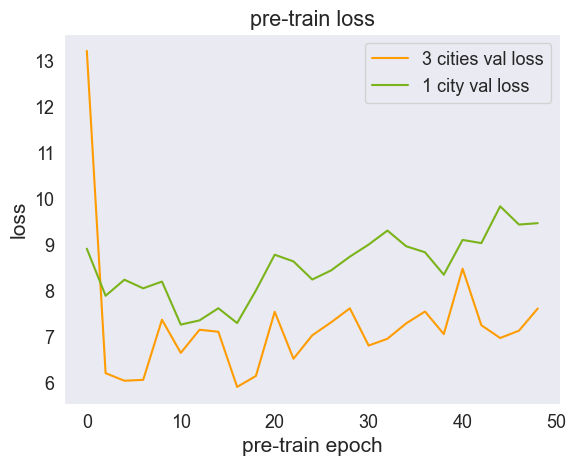

In [16]:
from PaperCrawlerUtil.common_util import *
import matplotlib.pyplot as plt

x_pre = np.array([i for i in range(50)])
x_fine = np.array([i for i in range(80)])
xx = []
y1 = []
y3 = []
f = 15
for i in range(50):
    if i % 2 == 0:
        y3.append(three_city["train_target_val_loss"][1:][i])
        y1.append(one_city["train_target_val_loss"][1:][i])
        xx.append(i)
plt.rcParams.update({'font.size': 13})
plt.plot(xx, y3, label="3 cities val loss", color=c[0])
plt.plot(xx, y1, label="1 city val loss", color=c[1])
plt.legend()
plt.xlabel('pre-train epoch', fontsize=f)
plt.ylabel('loss', fontsize=f)
plt.grid()
plt.title('pre-train loss')
plt.show()
plt.close()

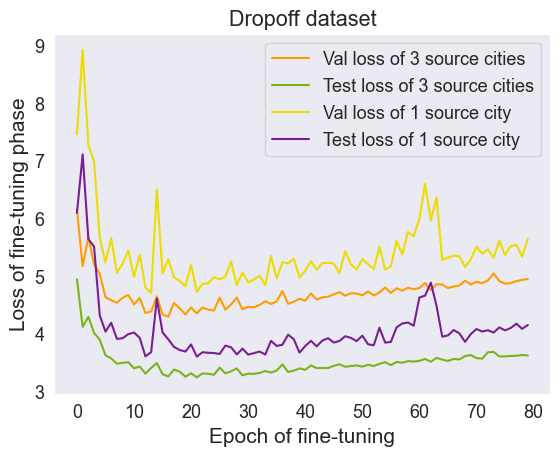

In [17]:

plt.subplots_adjust(bottom=0.15, top=0.9)
plt.plot(x_fine, three_city["target_train_val_loss"], label="Val loss of 3 source cities", color=c[0])

plt.plot(x_fine, three_city["target_train_test_loss"], label="Test loss of 3 source cities", color=c[1])
plt.plot(x_fine, one_city["target_train_val_loss"], label="Val loss of 1 source city", color=c[2])

plt.plot(x_fine, one_city["target_train_test_loss"], label="Test loss of 1 source city", color=c[3])
plt.legend()
plt.xlabel('Epoch of fine-tuning', fontsize=f)
plt.ylabel('Loss of fine-tuning phase', fontsize=f)
plt.title('Dropoff dataset')
plt.grid()
plt.show()
plt.close()

C:\Users\李武第\AppData\Local\Temp\ipykernel_8232\3531604513.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\李武第\AppData\Local\Temp\ipykernel_8232\3531604513.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


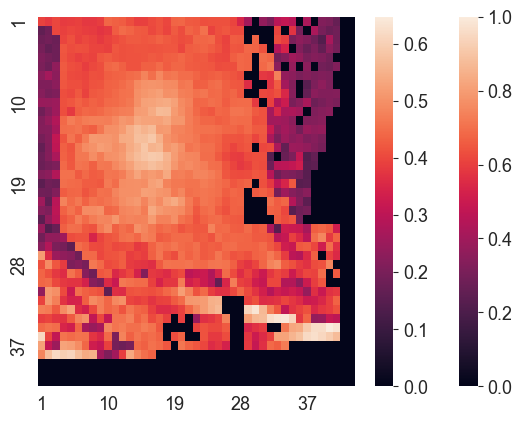

In [19]:

v = three_city["virtual_city"]
mask_v = v.sum(0) > 0
import seaborn as sns
fig = sns.heatmap(mask_v)
fig = fig.get_figure()
fig.show()
weight = np.zeros((v.shape[1], v.shape[2]))
count = 0
for i in range(len(three_city2["source_weight_list"][85])):
    x, y = idx_1d22d(i, v.shape)
    if mask_v[x][y]:
        t = three_city2["source_weight_list"][85][count]
        weight[x][y] = t
        count = count + 1

fig = sns.heatmap(weight)

ticks = fig.get_xticks()
ticks2 = fig.get_yticks()
ticksn = []
ticks2n = []
for i in range(len(ticks)):
    if i % 3 == 0:
        ticksn.append(int(ticks[i]) + 1)

    else:
        ticksn.append("")

for i in range(len(ticks2)):
    if i % 3 == 0:

        ticks2n.append(int(ticks2[i]) + 1)
    else:

        ticks2n.append("")
fig.set_xticklabels(ticksn)
fig.set_yticklabels(ticks2n)
fig = fig.get_figure()
fig.show()

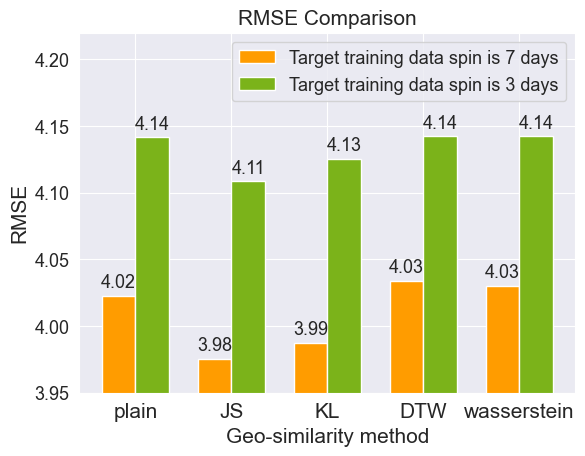

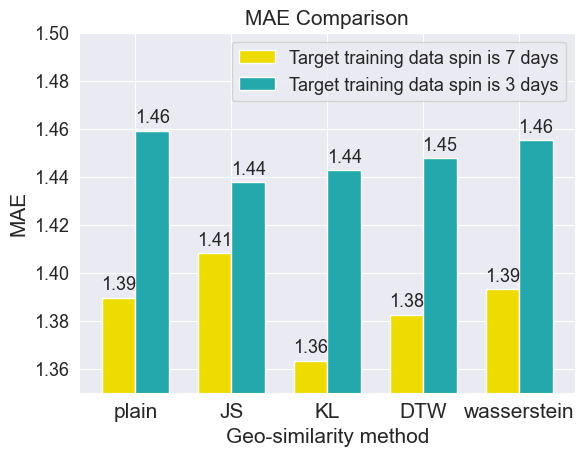

In [21]:

import matplotlib.pyplot as plt
import numpy as np
x_labels = ['plain', 'JS', 'KL', 'DTW', 'wasserstein']

fig, ax = plt.subplots()
ax.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(bottom=0.15, top=0.9)
bar_width = 0.35
x = np.arange(len(x_labels))
f = 15
rects1 = ax.bar(x - bar_width / 2, data['7-day-rmse'], bar_width, label='Target training data spin is 7 days', color=c[0])
rects2 = ax.bar(x + bar_width / 2, data['3-day-rmse'], bar_width, label='Target training data spin is 3 days', color=c[1])
plt.ylim(3.95, 4.22)
ax.set_xlabel('Geo-similarity method', fontsize=f)
ax.set_ylabel('RMSE', fontsize=f)
ax.set_title('RMSE Comparison', fontsize=f)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=f)
ax.legend(fontsize=13)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(round(height, 2)),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
fig2, ax2 = plt.subplots()
ax2.tick_params(axis='y', labelsize=13)
plt.subplots_adjust(bottom=0.15, top=0.9)
rects3 = ax2.bar(x - bar_width / 2, data['7-day-mae'], bar_width, label='Target training data spin is 7 days', color=c[2])
rects4 = ax2.bar(x + bar_width / 2, data['3-day-mae'], bar_width, label='Target training data spin is 3 days', color=c[4])
plt.ylim(1.35, 1.5)
ax2.set_xlabel('Geo-similarity method', fontsize=f)
ax2.set_ylabel('MAE', fontsize=f)
ax2.set_title('MAE Comparison', fontsize=f)
ax2.set_xticks(x)
ax2.set_xticklabels(x_labels, fontsize=f)
ax2.legend(fontsize=13)

for rect in rects3 + rects4:
    height = rect.get_height()
    ax2.annotate('{}'.format(round(height, 2)),
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()
